In [45]:
import pymc3 as pm
import numpy as np
%matplotlib inline
from IPython.core.pylabtools import figsize
import matplotlib.pyplot as plt
import scipy.stats as stats
import pandas as pd
import random
figsize(12.5, 4)

## Landscape Error

We model our estimated landscape area using 3 error components:

$$\hat{LA} = LA * \epsilon_{classification} * \epsilon_{boundary} * \epsilon_{landuse}$$

Where

* $LA$ is the true amount of residential landscape area within the service area of a given utility.
* $\epsilon_{classification}$ is a percent error caused by improper classification in the land cover algorithm.
* $\epsilon_{boundary}$ is a percent error caused by clipping to an improper boundary polygon.
* $\epsilon_{landuse}$ is a percent error caused by clipping to improper residential areas.

### Classification Error

Accuracy across the state has been assessed by taking a random sample of pixels and comparing these against reference labels assigned by a researcher. This pixel-based accuracy assessment is then used to generate error bounds on the total amount of estimated landscape area according to the methodology outlined by Olofsson et al. (2013).

This results in a standard error of 3.8%. That is, $se_{classification} = 0.038$

However, we expect the error to increase when classifying at the level of individual water retailers, and we model this through an increased variance of the classification error at the retailer level. Because we do not have a detailed accuracy assessment at this level, we must make an assumption about our prior beliefs.

We do this by assuming that the retailer-level classification error is log-normally distributed with $mu=0$ and a standard error twice the statewide levels $2*se_{classification} = 0.076$.

Our prior error term for the classification is thus

$$\epsilon_{classification} \sim Lognormal(\mu=0, \sigma = 0.076)$$

### Boundary Error

The Utility boundary polygons utilized are not guaranteed to be correct, but manual inspection has shown that most of them are, and those with errors tend to be minor. To capture this we model our boundary error according to an assumed prior distribution as before. We err on the side of caution and choose a spread parameter of 0.1 (10%). This is larger than what is typically observed in practice.

$$\epsilon_{boundary} \sim Lognormal(\mu=0, \sigma = 0.1)$$

### Land Use Error

The land use dataset used to isolate residential areas is similarly imperfect, but correct in the vast majority of cases. We model this error in the same manner as the boundary error because both result in multiplicative error caused by cropping of land cover classifications. Again, a spread parameter of 10% aligns with prior beliefs based on manual inspection.

$$\epsilon_{landuse} \sim Lognormal(\mu=0, \sigma = 0.1)$$

## ET Error

There are several possible sources of error when estimating evapotranspiration (ET) using the algorithm described in the methodology document. Three major sources include
1. Measurement/estimation error at CIMIS stations
2. Algrithm-induced error caused by our estimation methodology (inverse distance-weighted average of 10 nearest stations to utility service area centroid)
3. Approximation error caused by attributing a single point estimate of ET (at service area centroid) to all the landscape area in a service area that may span a large and diverse geographic region.

The first source is out of our control, and no error bounds are provided in the CIMIS source data. The third is addressable in future iterations through the use of ET data with a higher spatial resolution and the creation of parcel-level outdoor water budgets. For now we do not model these, and instead focus on the second error source: error induced by our estimation algorithm.

We can again model the errors as relative

$$\hat{ET} = ET * \epsilon_{et}$$

but this time we can measure the error distribution directly.

#### Error Calculation

To briefly recap the current methodology, ET at a given point $p$ is estimated as the inverse distance-weighted average of the ET readings at the 10 nearest CIMIS stations to $p$, with more weight given to nearer stations and less weight given to more distant stations. 

When estimating utility targets, $p$ is chosen as the centroid of the utility service area. To estimate ET errors, we instead choose $p$ as the location of a CIMIS station, and estimate ET using the 10 nearest stations (excluding the one located at point $p$). This gives an estimated ET from our algorithm, as well as a true ET as measured by the station located at $p$. Relative errors are then calculated as $ET_{est} / ET_{true}$. 

The distribution of the errors for monthly ET is shown below.

In [2]:
df = pd.read_csv("data/et_estimates_with_truth.csv")

Mean monthly error:  1.015
Std. dev. of monthly error:  0.13
5/95 percentiles:  [ 0.84088676  1.23041756]


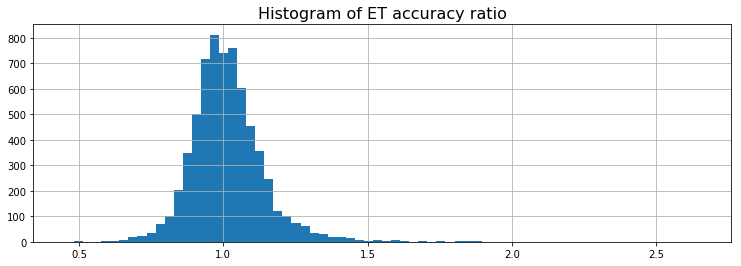

In [92]:
df_conditional = df #[df.et_month == 8]
lognormal_et_accuracy = df_conditional.accuracy_ratio[df_conditional.accuracy_ratio < 3]

## Landscape Error
print "Mean monthly error: ", np.round(lognormal_et_accuracy.mean(), 3)
print "Std. dev. of monthly error: ", np.round(lognormal_et_accuracy.std(), 3)
print "5/95 percentiles: ", np.percentile(lognormal_et_accuracy, [5, 95])
lognormal_et_accuracy.hist(bins = 70)
plt.title("Histogram of ET accuracy ratio", fontsize=16)

## Overall Error

The equation for the the estimated outdoor efficiency targets used in this methodology is

$$Outdoor Target = Outdoor Standard * \hat{LA} * \hat{ET} * Conversion Factor$$

Combining the outdoor standard and the conversion factor into a constant $C$, and substituting in our error models gives

$$Outdoor Target = C * (LA *  \epsilon_{classification} * \epsilon_{boundary} * \epsilon_{landuse}) * (ET* \epsilon_{et})$$

So, we can calculate the overall error for the outdoor target as the product of the individual error components. This is done using a monte carlo simulation, where random samples are drawn from our prior distributions, or from the empirical error distribution in the case of ET. 

In [39]:
with pm.Model() as model:
    et_prior = pm.Lognormal("et_prior", mu=0, sd=0.1, observed=lognormal_et_accuracy)
#     has_boundary_error = pm.Bernoulli("has_boundary_error", p=0.5)
    boundary_prior = pm.Lognormal("boundary_prior", mu=0, sd=0.1)
    landuse_prior = pm.Lognormal("landuse_prior", mu=0, sd=0.1)
    classification_prior = pm.Lognormal("classification_prior", mu=0, sd=2*0.038)
    outdoor_error_dist = pm.Deterministic("outdoor_error_dist", et_prior*boundary_prior*landuse_prior*classification_prior)

In [68]:
class_samples = [random.choice(list(lognormal_et_accuracy))*boundary_prior.random()*landuse_prior.random()*classification_prior.random() for i in xrange(20000)]

Mean monthly error:  1.03
Std. dev. of monthly error:  0.214
5/95 percentiles:  [ 0.73069255  1.407863  ]


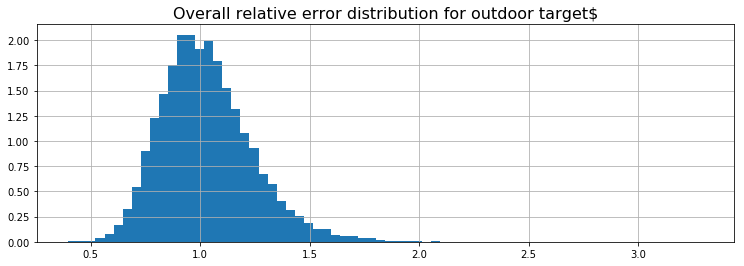

In [96]:
overal_error_dist = pd.Series(class_samples)

print "Mean monthly error: ", np.round(overal_error_dist.mean(), 3)
print "Std. dev. of monthly error: ", np.round(overal_error_dist.std(), 3)
print "5/95 percentiles: ", np.percentile(overal_error_dist, [5, 95])


overal_error_dist.hist(bins=70, normed=True, histtype="stepfilled")
plt.title("Overall relative error distribution for outdoor target$", fontsize=16)
figsize(12.5, 4)

Under the previous assumptions, we can therefore expect 90% of the water retailers to have their true outdoor targets within approximately $\pm$40% of the estimated target.

## References

Olofsson, P., Foody, G. M., Stehman, S. V., & Woodcock, C. E. (2013). Making better use of accuracy data in land change studies: Estimating accuracy and area and quantifying uncertainty using stratified estimation. Remote Sensing of Environment, 129, 122-131.